# Imports 

Business Problem: NYPD has a historically studied problem of needless stop-and-frisks, especially concerning BIPOC folks. The rate of stop-and-frisks that do not lead to arrests must be brought down. 


**In no way does this project advocate for more citywide arrests, but rather it advocates for NYPD to make more informed, better choices.**


Business Solution: NYPD can start an integrating machine learning to improve the timing of stops. By stopping fewer people when it’s unlikely that the stop will lead to an arrest, NYPD can work more effectively and improve the return on the investment the public has put into them. 


Data Understanding: I’ll be inspecting data going back 11 years to 2011, however stop-and-frisks were deemed unconstitutional in 2013, causing the rates and patterns of stops to change. Therefore I’ll use data from 2014 onwards to model. There will automatically be discrepancies since the pandemic in 2020 affected many time-oriented patterns of behavior and policing. 


**I am using time data and not categorical data specifically because it’s unethical to predict exactly what demographics of people will commit crimes in the future, especially with race. Conversely, there is provable seasonality of stops that do not lead to an arrest, so I will use that information instead.**


How this model is intended to be used: This model is designed to predict the next month’s rates of stops that do not lead to an arrest and be used on a daily rolling basis for police planning one month out. Designed to be retraining on a constant basis, as new data becomes available. 


Data Preparation: I prepared the data in Data Prep notebook within this repo, to clean up the DateTime columns and setting that as the index. This task was complex, due to high amounts of inconsistency in the way this data was recorded. I used string manipulation intuitively instead of back or forward-filling when I could, to preserve as much original data as possible.


Modeling: I am using SARIMA exclusively for this univariate project. In the future, I’d like to make a model that uses the timeline of each NYPD precinct as a separate variable, but as is, I am using only the citywide timeline. SARIMA is an appropriate model for this case because Neural Networks do not lend themselves to univariate problems well, and this would not be an appropriate use of Facebook’s Prophet, which is specialized for hourly, daily or weekly seasonality where this data’s seasonality is yearly. Facebook Prophet is also not sensative enough to new data for our modeling purposes. 


Evaluation: VALIDATION DATA SAID WHAT?


To Do List:

- remove code not in final notebook
- comment all code
- analyze modeling findings 
- VALIDATION SET
- CONCLUSION 

ASK FOR HELP: 
1) making sure I'm understanding MAE score properly 
2) making sure I'm understanding diagnostic plots correctly and their usage 
3) 

# Functions

In [1328]:
def visualize_diagnostics(preds, train):
    
    """
    DOCSTRING:
    This function expects an input of a list of predictions and a train 
    (or test/validation) set of original data. It produces a plot for visual
    diagnostics of model's predictions. 
    
    We are looking to check both the range of values in the residuals, 
    and to visually inspect the residuals for decerable patterns on the blue line. 
    On the orange line we see the standard deviation of those residuals 
    within a window of 2 weeks (starting on a two week lag) 
    which shows us how the standard deviation of those residuals grow 
    or recede over time.) 
    
    We also get two statistics: 
    1) the overall standard deviation of the residuals. 
    2) the overall variance of the residuals. 
    We want both of these statistics to be smaller with each model itteration.
    """

    fig, ax = plt.subplots()
    residuals = preds - train.squeeze()
    residuals
    ax.plot(residuals.index, residuals)
    ax.plot(residuals.index, residuals.rolling(2).std())
    
    print(f'STANDARD DEVIATION OF RESIDUALS: {residuals.std()},\
    VARIANCE OF RESIDUALS: {residuals.var()}')

    plt.title("Residuals")


questions:

Diagnostic plots: what does the orange line and rolling residuals show? 


In [1329]:
# importing padas, numpy, matplotlib, statsmodels, statsmodels tsa, 
# datetime, and auto arima 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import json
import glob

from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA

plt.rcParams['figure.figsize'] = (12, 4)
import geopandas as gpd
import statsmodels
import statsmodels.tsa.api as tsa

from datetime import time
import pmdarima as pm
from pmdarima.arima import ADFTest


import folium

print(f'statsmodels version : {statsmodels.__version__}')
print(f' pmdarima version : {pm.__version__}')
print(f' pandas version : {pd. __version__}')
print(f' geopandas version: {gpd.__version__}')

statsmodels version : 0.13.2
 pmdarima version : 1.8.5
 pandas version : 1.1.3
 geopandas version: 0.11.1


In [1330]:
def get_mae(y_true, predictions):
    """DOCSTRING:
    takes original data as an array, and the predicted values as an array
    and returns the mean of the absolute values of errors"""
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

# taken from https://datagy.io/mae-python/

In [1331]:
def last_year_visualize_preds(conf_int_last_year):
    
    """DOCSTRING:
    intakes a df of upper and lower confidence interval for a model spanning
    52 weeks or intervals. outputs a visualization showing the original data
    in a blue line and the 95% confidence interval of the algorithm as a green
    zone between two green lines. The upper green line corresponds to an
    upper limit, the lower green line corresponds to a lower limit."""

    fig, ax = plt.subplots()

    lower = sns.lineplot(data = conf_int_last_year, 
                 y = 'lower NOT_ARRESTED_RATE',
                x = conf_int_last_year.index, color = 'g')

    upper = sns.lineplot(data = conf_int_last_year, 
                 y = 'upper NOT_ARRESTED_RATE',
                x = conf_int_last_year.index, color = 'g')

    sns.lineplot(data = train_last_year, y = "NOT_ARRESTED_RATE",
                 x = train_last_year.index, color = 'blue', ax = ax)

    plt.fill_between(train_last_year.index, 
                     conf_int_last_year['upper NOT_ARRESTED_RATE'],
                     conf_int_last_year['lower NOT_ARRESTED_RATE'], 
                    color = 'g', alpha = 0.1)
    fig.tight_layout()

In [1335]:
df = pd.read_csv('stop_and_frisk_w_race.csv', index_col= "DATE_TIME")
df.head()

Unique_ID SUSPECT_ARRESTED_FLAG SUSPECT_RACE_DESCRIPTION  \
DATE_TIME                                                                    
2011-01-01 00:00          0                     N                 E. ASIAN   
2011-01-01 00:10          1                     N                    BLACK   
2011-01-01 00:10          2                     N                    BLACK   
2011-01-01 00:10          3                     N                    BLACK   
2011-01-01 00:15          4                     N           WHITE HISPANIC   

                  PRECINCT  
DATE_TIME                   
2011-01-01 00:00       102  
2011-01-01 00:10       101  
2011-01-01 00:10        73  
2011-01-01 00:10        70  
2011-01-01 00:15        52

In [1336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545827 entries, 2011-01-01 00:00 to 2021-12-31 23:18
Data columns (total 4 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   Unique_ID                 1545827 non-null  int64 
 1   SUSPECT_ARRESTED_FLAG     1545827 non-null  object
 2   SUSPECT_RACE_DESCRIPTION  1545827 non-null  object
 3   PRECINCT                  1545827 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 59.0+ MB


# EDA: inspecting totals 

## Arrested vs. Not Arrested Totals

In [1337]:
df_dummied = pd.get_dummies(df, columns = ['SUSPECT_ARRESTED_FLAG', 
                                           'SUSPECT_RACE_DESCRIPTION',
                                          'PRECINCT'])

In [1338]:
df_dummied.head()

Unique_ID  SUSPECT_ARRESTED_FLAG_N  SUSPECT_ARRESTED_FLAG_Y  \
DATE_TIME                                                                       
2011-01-01 00:00          0                        1                        0   
2011-01-01 00:10          1                        1                        0   
2011-01-01 00:10          2                        1                        0   
2011-01-01 00:10          3                        1                        0   
2011-01-01 00:15          4                        1                        0   

                  SUSPECT_RACE_DESCRIPTION_BLACK  \
DATE_TIME                                          
2011-01-01 00:00                               0   
2011-01-01 00:10                               1   
2011-01-01 00:10                               1   
2011-01-01 00:10                               1   
2011-01-01 00:15                               0   

                  SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC  \
DATE_TIME                                                   
2011-01-01 00:00                                        0   
2011-01-01 00:10                                        0   
2011-01-01 00:10                                        0   
2011-01-01 00:10                                        0   
2011-01-01 00:15                                        0   

                  SUSPECT_RACE_DESCRIPTION_E. ASIAN  \
DATE_TIME                                             
2011-01-01 00:00                                  1   
2011-01-01 00:10                                  0   
2011-01-01 00:10                                  0   
2011-01-01 00:10                                  0   
2011-01-01 00:15                                  0   

                  SUSPECT_RACE_DESCRIPTION_NATIVE  \
DATE_TIME                                           
2011-01-01 00:00                                0   
2011-01-01 00:10                                0   
2011-01-01 00:10                                0   
2011-01-01 00:10                                0   
2011-01-01 00:15                                0   

                  SUSPECT_RACE_DESCRIPTION_OTHER  \
DATE_TIME                                          
2011-01-01 00:00                               0   
2011-01-01 00:10                               0   
2011-01-01 00:10                               0   
2011-01-01 00:10                               0   
2011-01-01 00:15                               0   

                  SUSPECT_RACE_DESCRIPTION_UNKNOWN  \
DATE_TIME                                            
2011-01-01 00:00                                 0   
2011-01-01 00:10                                 0   
2011-01-01 00:10                                 0   
2011-01-01 00:10                                 0   
2011-01-01 00:15                                 0   

                  SUSPECT_RACE_DESCRIPTION_W. ASIAN  ...  PRECINCT_110  \
DATE_TIME                                            ...                 
2011-01-01 00:00                                  0  ...             0   
2011-01-01 00:10                                  0  ...             0   
2011-01-01 00:10                                  0  ...             0   
2011-01-01 00:10                                  0  ...             0   
2011-01-01 00:15                                  0  ...             0   

                  PRECINCT_111  PRECINCT_112  PRECINCT_113  PRECINCT_114  \
DATE_TIME                                                                  
2011-01-01 00:00             0             0             0             0   
2011-01-01 00:10             0             0             0             0   
2011-01-01 00:10             0             0             0             0   
2011-01-01 00:10             0             0             0             0   
2011-01-01 00:15             0             0             0             0   

                  PRECINCT_115  PRECINCT_120  PRECINCT_121  PRECINCT_122  \
DATE_TIME                  

In [1339]:
df_dummied

Unique_ID  SUSPECT_ARRESTED_FLAG_N  SUSPECT_ARRESTED_FLAG_Y  \
DATE_TIME                                                                       
2011-01-01 00:00          0                        1                        0   
2011-01-01 00:10          1                        1                        0   
2011-01-01 00:10          2                        1                        0   
2011-01-01 00:10          3                        1                        0   
2011-01-01 00:15          4                        1                        0   
...                     ...                      ...                      ...   
2021-12-31 23:03    1545822                        1                        0   
2021-12-31 23:03    1545823                        1                        0   
2021-12-31 23:03    1545824                        1                        0   
2021-12-31 23:03    1545825                        0                        1   
2021-12-31 23:18    1545826                        0                        1   

                  SUSPECT_RACE_DESCRIPTION_BLACK  \
DATE_TIME                                          
2011-01-01 00:00                               0   
2011-01-01 00:10                               1   
2011-01-01 00:10                               1   
2011-01-01 00:10                               1   
2011-01-01 00:15                               0   
...                                          ...   
2021-12-31 23:03                               0   
2021-12-31 23:03                               0   
2021-12-31 23:03                               0   
2021-12-31 23:03                               0   
2021-12-31 23:18                               1   

                  SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC  \
DATE_TIME                                                   
2011-01-01 00:00                                        0   
2011-01-01 00:10                                        0   
2011-01-01 00:10                                        0   
2011-01-01 00:10                                        0   
2011-01-01 00:15                                        0   
...                                                   ...   
2021-12-31 23:03                                        0   
2021-12-31 23:03                                        0   
2021-12-31 23:03                                        0   
2021-12-31 23:03                                        0   
2021-12-31 23:18                                        0   

                  SUSPECT_RACE_DESCRIPTION_E. ASIAN  \
DATE_TIME                                             
2011-01-01 00:00                                  1   
2011-01-01 00:10                                  0   
2011-01-01 00:10                                  0   
2011-01-01 00:10                                  0   
2011-01-01 00:15                                  0   
...                                             ...   
2021-12-31 23:03                                  0   
2021-12-31 23:03                                  0   
2021-12-31 23:03                                  0   
2021-12-31 23:03                                  0   
2021-12-31 23:18                                  0   

                  SUSPECT_RACE_DESCRIPTION_NATIVE  \
DATE_TIME                                           
2011-01-01 00:00                                0   
2011-01-01 00:10                                0   
2011-01-01 00:10                                0   
2011-01-01 00:10                                0   
2011-01-01 00:15                                0   
...                                           ...   
2021-12-31 23:03                                0   
2021-12-31 23:03                                0   
2021-12-31 23:03                                0   
2021-12-31 23:03                                0   
2021-12-31 23:18                                0   

                  SUSPECT_RACE_DESCRIPTION_OTHER  \
DATE_TIME                          

In [1340]:
arrested_cols = ['SUSPECT_ARRESTED_FLAG_N', 'SUSPECT_ARRESTED_FLAG_Y']
race_cols = [col for col in df_dummied.columns if 'RACE' in col]
precinct_cols = [col for col in df_dummied.columns if 'PRECINCT' in col]

arrested_df = df_dummied.drop(columns=[col for col in df_dummied.columns if col not in arrested_cols])
arrested_df.head()

SUSPECT_ARRESTED_FLAG_N  SUSPECT_ARRESTED_FLAG_Y
DATE_TIME                                                         
2011-01-01 00:00                        1                        0
2011-01-01 00:10                        1                        0
2011-01-01 00:10                        1                        0
2011-01-01 00:10                        1                        0
2011-01-01 00:15                        1                        0

In [1341]:
arrested_stats = pd.DataFrame(arrested_df.sum())
arrested_stats.rename({0 : "Counts"}, axis = 1, inplace = True)
arrested_stats

Counts
SUSPECT_ARRESTED_FLAG_N  1425853
SUSPECT_ARRESTED_FLAG_Y   119974

Visualizing the total arrested vs not arrested

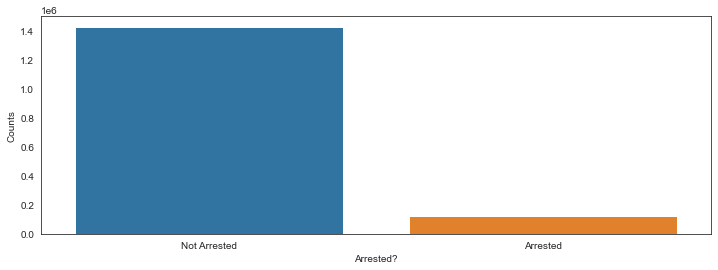

In [1342]:
sns.set_style('white')

arrested_plot = sns.barplot(x = arrested_stats.index, y = 'Counts', data = arrested_stats,)
arrested_plot.set_xticklabels(['Not Arrested', 'Arrested'])
arrested_plot.set_xlabel('Arrested?');

## Arrests by Race Totals

In [1343]:
arrs_by_race_df = df_dummied.drop(columns=[col for col in df_dummied.columns if col  in precinct_cols])
arrs_by_race_df = arrs_by_race_df.drop(columns = 'Unique_ID')
arrs_by_race_df

SUSPECT_ARRESTED_FLAG_N  SUSPECT_ARRESTED_FLAG_Y  \
DATE_TIME                                                            
2011-01-01 00:00                        1                        0   
2011-01-01 00:10                        1                        0   
2011-01-01 00:10                        1                        0   
2011-01-01 00:10                        1                        0   
2011-01-01 00:15                        1                        0   
...                                   ...                      ...   
2021-12-31 23:03                        1                        0   
2021-12-31 23:03                        1                        0   
2021-12-31 23:03                        1                        0   
2021-12-31 23:03                        0                        1   
2021-12-31 23:18                        0                        1   

                  SUSPECT_RACE_DESCRIPTION_BLACK  \
DATE_TIME                                          
2011-01-01 00:00                               0   
2011-01-01 00:10                               1   
2011-01-01 00:10                               1   
2011-01-01 00:10                               1   
2011-01-01 00:15                               0   
...                                          ...   
2021-12-31 23:03                               0   
2021-12-31 23:03                               0   
2021-12-31 23:03                               0   
2021-12-31 23:03                               0   
2021-12-31 23:18                               1   

                  SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC  \
DATE_TIME                                                   
2011-01-01 00:00                                        0   
2011-01-01 00:10                                        0   
2011-01-01 00:10                                        0   
2011-01-01 00:10                                        0   
2011-01-01 00:15                                        0   
...                                                   ...   
2021-12-31 23:03                                        0   
2021-12-31 23:03                                        0   
2021-12-31 23:03                                        0   
2021-12-31 23:03                                        0   
2021-12-31 23:18                                        0   

                  SUSPECT_RACE_DESCRIPTION_E. ASIAN  \
DATE_TIME                                             
2011-01-01 00:00                                  1   
2011-01-01 00:10                                  0   
2011-01-01 00:10                                  0   
2011-01-01 00:10                                  0   
2011-01-01 00:15                                  0   
...                                             ...   
2021-12-31 23:03                                  0   
2021-12-31 23:03                                  0   
2021-12-31 23:03                                  0   
2021-12-31 23:03                                  0   
2021-12-31 23:18                                  0   

                  SUSPECT_RACE_DESCRIPTION_NATIVE  \
DATE_TIME                                           
2011-01-01 00:00                                0   
2011-01-01 00:10                                0   
2011-01-01 00:10                                0   
2011-01-01 00:10                                0   
2011-01-01 00:15                                0   
...                                           ...   
2021-12-31 23:03                                0   
2021-12-31 23:03                                0   
2021-12-31 23:03                                0   
2021-12-31 23:03                                0   
2021-12-31 23:18                                0   

                  SUSPECT_RACE_DESCRIPTION_OTHER  \
DATE_TIME                                          
2011-01-01 00:00                               0   
2011-01-01 00:10                               0   
2011-01-01 00:10      

In [1344]:
arrs_by_race_df.rename({
          'SUSPECT_RACE_DESCRIPTION_BLACK' : 'BLACK',
          'SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC' : 'BLACK_HISPANIC',
          'SUSPECT_RACE_DESCRIPTION_E. ASIAN' : 'E._ASIAN', 
          'SUSPECT_RACE_DESCRIPTION_NATIVE' : 'NATIVE',
          'SUSPECT_RACE_DESCRIPTION_OTHER': 'OTHER',
          'SUSPECT_RACE_DESCRIPTION_UNKNOWN' : 'UNKNOWN',
          'SUSPECT_RACE_DESCRIPTION_W. ASIAN' : 'W._ASIAN',
          'SUSPECT_RACE_DESCRIPTION_WHITE' : 'WHITE',
          'SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC' : 'WHITE_HISPANIC'},
         axis = 1, inplace = True)

In [1345]:
arrs_by_race_df

SUSPECT_ARRESTED_FLAG_N  SUSPECT_ARRESTED_FLAG_Y  BLACK  \
DATE_TIME                                                                   
2011-01-01 00:00                        1                        0      0   
2011-01-01 00:10                        1                        0      1   
2011-01-01 00:10                        1                        0      1   
2011-01-01 00:10                        1                        0      1   
2011-01-01 00:15                        1                        0      0   
...                                   ...                      ...    ...   
2021-12-31 23:03                        1                        0      0   
2021-12-31 23:03                        1                        0      0   
2021-12-31 23:03                        1                        0      0   
2021-12-31 23:03                        0                        1      0   
2021-12-31 23:18                        0                        1      1   

                  BLACK_HISPANIC  E._ASIAN  NATIVE  OTHER  UNKNOWN  W._ASIAN  \
DATE_TIME                                                                      
2011-01-01 00:00               0         1       0      0        0         0   
2011-01-01 00:10               0         0       0      0        0         0   
2011-01-01 00:10               0         0       0      0        0         0   
2011-01-01 00:10               0         0       0      0        0         0   
2011-01-01 00:15               0         0       0      0        0         0   
...                          ...       ...     ...    ...      ...       ...   
2021-12-31 23:03               0         0       0      0        0         0   
2021-12-31 23:03               0         0       0      0        1         0   
2021-12-31 23:03               0         0       0      0        0         0   
2021-12-31 23:03               0         0       0      0        0         0   
2021-12-31 23:18               0         0       0      0        0         0   

                  WHITE  WHITE_HISPANIC  
DATE_TIME                                
2011-01-01 00:00      0               0  
2011-01-01 00:10      0               0  
2011-01-01 00:10      0               0  
2011-01-01 00:10      0               0  
2011-01-01 00:15      0               1  
...                 ...             ...  
2021-12-31 23:03      0               1  
2021-12-31 23:03      0               0  
2021-12-31 23:03      0               1  
2021-12-31 23:03      0               1  
2021-12-31 23:18      0               0  

[1545827 rows x 11 columns]

In [1346]:
outcomes = ['SUSPECT_ARRESTED_FLAG_N', 'SUSPECT_ARRESTED_FLAG_Y']


arrs_by_race = arrs_by_race_df.pivot_table(index = outcomes, aggfunc = 'sum')
arrs_by_race = arrs_by_race.reset_index(drop= True).transpose()
arrs_by_race.rename({0 : 'ARRESTED', 1 : 'NOT ARRESTED'}, axis = 1, 
                    inplace = True)
arrs_by_race.sort_values(by  = 'NOT ARRESTED', inplace = True)
arrs_by_race = arrs_by_race.astype(int)
arrs_by_race.style.bar()

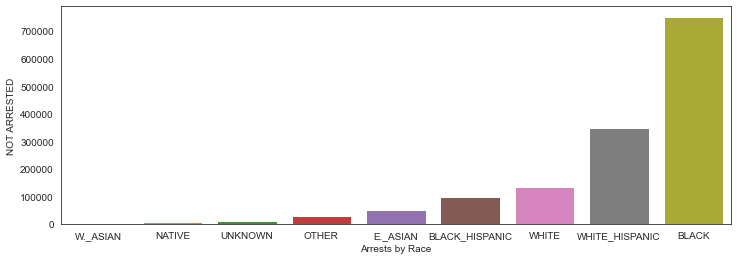

In [1347]:
arrs_by_race_plot = sns.barplot(x = arrs_by_race.index, 
                                y = 'NOT ARRESTED', 
                                data = arrs_by_race)

arrs_by_race_plot.set_xlabel('Arrests by Race');

## Arrest by Precinct Totals

In [1348]:
arrs_by_precinct_df = df_dummied.drop(columns=[col for col in df_dummied.columns if col in race_cols])
arrs_by_precinct_df = arrs_by_precinct_df.drop(columns = "Unique_ID")
arrs_by_precinct_df

SUSPECT_ARRESTED_FLAG_N  SUSPECT_ARRESTED_FLAG_Y  \
DATE_TIME                                                            
2011-01-01 00:00                        1                        0   
2011-01-01 00:10                        1                        0   
2011-01-01 00:10                        1                        0   
2011-01-01 00:10                        1                        0   
2011-01-01 00:15                        1                        0   
...                                   ...                      ...   
2021-12-31 23:03                        1                        0   
2021-12-31 23:03                        1                        0   
2021-12-31 23:03                        1                        0   
2021-12-31 23:03                        0                        1   
2021-12-31 23:18                        0                        1   

                  PRECINCT_0  PRECINCT_1  PRECINCT_5  PRECINCT_6  PRECINCT_7  \
DATE_TIME                                                                      
2011-01-01 00:00           0           0           0           0           0   
2011-01-01 00:10           0           0           0           0           0   
2011-01-01 00:10           0           0           0           0           0   
2011-01-01 00:10           0           0           0           0           0   
2011-01-01 00:15           0           0           0           0           0   
...                      ...         ...         ...         ...         ...   
2021-12-31 23:03           0           0           0           0           0   
2021-12-31 23:03           0           0           0           0           0   
2021-12-31 23:03           0           0           0           0           0   
2021-12-31 23:03           0           0           0           0           0   
2021-12-31 23:18           0           0           0           0           0   

                  PRECINCT_9  PRECINCT_10  PRECINCT_13  ...  PRECINCT_110  \
DATE_TIME                                               ...                 
2011-01-01 00:00           0            0            0  ...             0   
2011-01-01 00:10           0            0            0  ...             0   
2011-01-01 00:10           0            0            0  ...             0   
2011-01-01 00:10           0            0            0  ...             0   
2011-01-01 00:15           0            0            0  ...             0   
...                      ...          ...          ...  ...           ...   
2021-12-31 23:03           0            0            0  ...             0   
2021-12-31 23:03           0            0            0  ...             0   
2021-12-31 23:03           0            0            0  ...             0   
2021-12-31 23:03           0            0            0  ...             0   
2021-12-31 23:18           0            0            0  ...             0   

                  PRECINCT_111  PRECINCT_112  PRECINCT_113  PRECINCT_114  \
DATE_TIME                                                                  
2011-01-01 00:00             0             0             0             0   
2011-01-01 00:10             0             0             0             0   
2011-01-01 00:10             0             0             0             0   
2011-01-01 00:10             0             0             0             0   
2011-01-01 00:15             0             0             0             0   
...                        ...           ...           ...           ...   
2021-12-31 23:03             0             0             0             0   
2021-12-31 23:03             0             0             0             0   
2021-12-31 23:03             0             0             0             0   
2021-12-31 23:03             0             0             0             0   
2021-12-31 23:18             0             0             0             0   

                  PRECINCT_115  PRECINCT_120  PRECINCT_121  PRECINCT_122  \

In [1349]:
arrs_by_precinct = arrs_by_precinct_df.pivot_table(index = outcomes, aggfunc = 'sum')
arrs_by_precinct = arrs_by_precinct.reset_index(drop= True).transpose()
arrs_by_precinct.rename({0 : 'ARRESTED', 1 : 'NOT ARRESTED'}, axis = 1, 
                    inplace = True)

arrs_by_precinct

ARRESTED  NOT ARRESTED
PRECINCT_0       113.0         319.0
PRECINCT_1       704.0        7857.0
PRECINCT_10     1010.0        6442.0
PRECINCT_100     912.0       10891.0
PRECINCT_101    1486.0       28719.0
...                ...           ...
PRECINCT_84     1017.0       12532.0
PRECINCT_88     1324.0       15001.0
PRECINCT_9      3146.0       11411.0
PRECINCT_90     1519.0       29910.0
PRECINCT_94      555.0        4795.0

[78 rows x 2 columns]

In [1350]:
arrs_by_precinct['DIFFERENCE'] = arrs_by_precinct['NOT ARRESTED'] - arrs_by_precinct['ARRESTED']
arrs_by_precinct.sort_values(by = 'DIFFERENCE', inplace = True)
arrs_by_precinct.astype(int).style.bar()

observations: 

In [1351]:
arrs_by_precinct.reset_index(inplace = True)

## visualizing outcome disparities by precinct 

<AxesSubplot:xlabel='Counts', ylabel='index'>

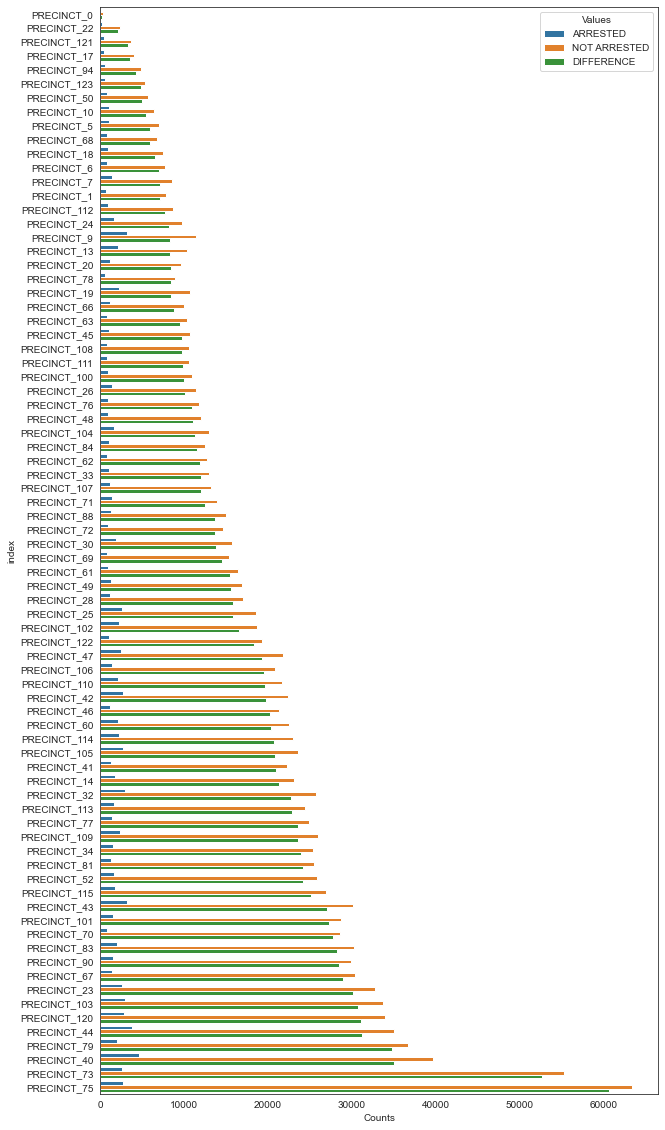

In [1352]:
plt.figure(figsize=(10, 20))

sns.barplot(data = arrs_by_precinct.melt(id_vars='index',
                                         value_name='Counts', 
                                         var_name='Values'),
            y='index', x='Counts', hue='Values')


## Arrests by Precinct On a Map

In [1353]:
arrs_by_precinct_map = arrs_by_precinct.copy()
vals = [x.split('_')[1] for x in arrs_by_precinct_map['index']]
arrs_by_precinct_map['index'] = vals
arrs_by_precinct_map.drop(0, inplace = True)
arrs_by_precinct_map

index  ARRESTED  NOT ARRESTED  DIFFERENCE
1     22     145.0        2294.0      2149.0
2    121     380.0        3692.0      3312.0
3     17     437.0        4002.0      3565.0
4     94     555.0        4795.0      4240.0
5    123     498.0        5338.0      4840.0
..   ...       ...           ...         ...
73    44    3752.0       35000.0     31248.0
74    79    1942.0       36667.0     34725.0
75    40    4626.0       39603.0     34977.0
76    73    2545.0       55248.0     52703.0
77    75    2668.0       63346.0     60678.0

[77 rows x 4 columns]

In [1354]:
arrs_by_precinct_map['index'] = arrs_by_precinct_map['index'].astype(int)
arrs_by_precinct_map['DIFFERENCE'] = arrs_by_precinct_map['DIFFERENCE'].astype(int)
arrs_by_precinct_map.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 1 to 77
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         77 non-null     int64  
 1   ARRESTED      77 non-null     float64
 2   NOT ARRESTED  77 non-null     float64
 3   DIFFERENCE    77 non-null     int64  
dtypes: float64(2), int64(2)
memory usage: 3.0 KB


to make a visualization using folium, I'll need a geojason file for the precincts, found here

citation: https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page

In [1355]:
with open ('tableau_data/precincts.json') as f:
    json_data = json.load(f)

In [1356]:
#change this to show the differences

my_thresh = arrs_by_precinct_map['NOT ARRESTED'].quantile((0, 0.25, 0.5, 0.75, 1)).tolist()

m = folium.Map(location=[40.693943, -73.985880], default_zoom_start=10)

folium.Choropleth(
    geo_data = json_data,
    name = "Sum of Stops That Did Not Lead To Arrest",
    data = arrs_by_precinct_map,
    columns = ["index", 'NOT ARRESTED'],
    key_on = "feature.properties.Precinct",
    fill_color = 'BuPu',
    fill_opacity = 0.75,
    line_opacity = 0.2,
    legend_name = "2011-2021 Sum of Stops That Do Not Lead To An Arrest",
    threshold_scale = my_thresh
).add_to(m)

folium.LayerControl().add_to(m)

m

# EDA: inspecting timelines

In [1357]:
df_dummied.index = pd.to_datetime(df_dummied.index)
df_dummied = df_dummied.sort_index()

## including before it was deemed unconstitutional 

<AxesSubplot:xlabel='DATE_TIME'>

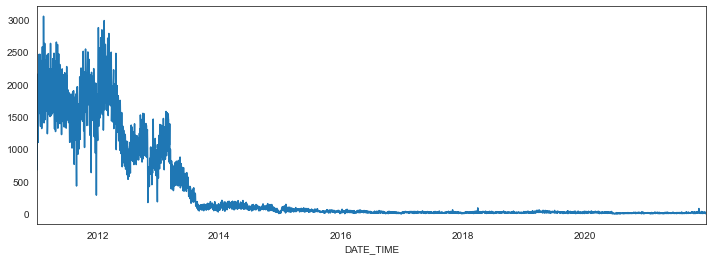

In [1358]:
by_day = df_dummied['SUSPECT_ARRESTED_FLAG_N'].resample('D').sum()
by_day.plot()

<AxesSubplot:xlabel='DATE_TIME'>

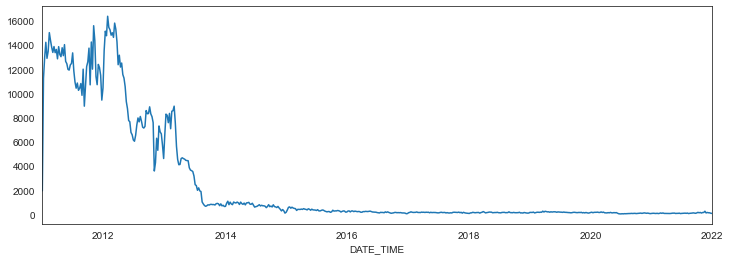

In [1359]:
by_week = df_dummied['SUSPECT_ARRESTED_FLAG_N'].resample('W').sum()
by_week.plot()

<AxesSubplot:xlabel='DATE_TIME'>

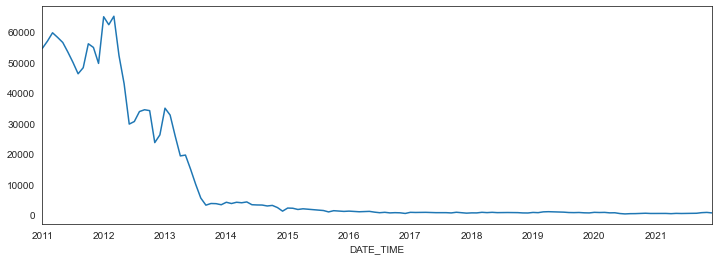

In [1360]:
by_month = df_dummied['SUSPECT_ARRESTED_FLAG_N'].resample('M').sum()
by_month.plot()

<AxesSubplot:xlabel='DATE_TIME'>

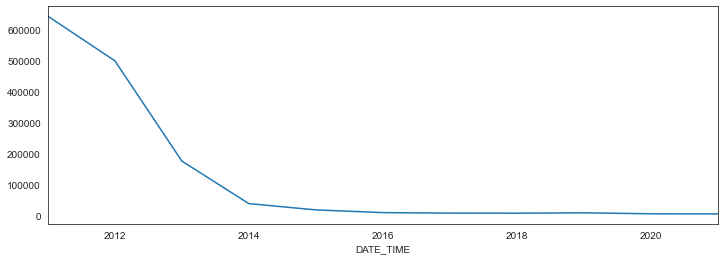

In [1361]:
by_year = df_dummied['SUSPECT_ARRESTED_FLAG_N'].resample('Y').sum()
by_year.plot()

## only after it was deemed unconstitutonal 

In [1362]:
fourteen_onward = df_dummied.loc['2014':]
fourteen_onward

Unique_ID  SUSPECT_ARRESTED_FLAG_N  \
DATE_TIME                                                 
2014-01-01 00:10:00    1410486                        1   
2014-01-01 00:20:00    1410487                        0   
2014-01-01 00:30:00    1410488                        1   
2014-01-01 00:30:00    1410489                        1   
2014-01-01 00:30:00    1410490                        1   
...                        ...                      ...   
2021-12-31 23:03:00    1545822                        1   
2021-12-31 23:03:00    1545823                        1   
2021-12-31 23:03:00    1545824                        1   
2021-12-31 23:03:00    1545825                        0   
2021-12-31 23:18:00    1545826                        0   

                     SUSPECT_ARRESTED_FLAG_Y  SUSPECT_RACE_DESCRIPTION_BLACK  \
DATE_TIME                                                                      
2014-01-01 00:10:00                        0                               1   
2014-01-01 00:20:00                        1                               0   
2014-01-01 00:30:00                        0                               1   
2014-01-01 00:30:00                        0                               1   
2014-01-01 00:30:00                        0                               1   
...                                      ...                             ...   
2021-12-31 23:03:00                        0                               0   
2021-12-31 23:03:00                        0                               0   
2021-12-31 23:03:00                        0                               0   
2021-12-31 23:03:00                        1                               0   
2021-12-31 23:18:00                        1                               1   

                     SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC  \
DATE_TIME                                                      
2014-01-01 00:10:00                                        0   
2014-01-01 00:20:00                                        1   
2014-01-01 00:30:00                                        0   
2014-01-01 00:30:00                                        0   
2014-01-01 00:30:00                                        0   
...                                                      ...   
2021-12-31 23:03:00                                        0   
2021-12-31 23:03:00                                        0   
2021-12-31 23:03:00                                        0   
2021-12-31 23:03:00                                        0   
2021-12-31 23:18:00                                        0   

                     SUSPECT_RACE_DESCRIPTION_E. ASIAN  \
DATE_TIME                                                
2014-01-01 00:10:00                                  0   
2014-01-01 00:20:00                                  0   
2014-01-01 00:30:00                                  0   
2014-01-01 00:30:00                                  0   
2014-01-01 00:30:00                                  0   
...                                                ...   
2021-12-31 23:03:00                                  0   
2021-12-31 23:03:00                                  0   
2021-12-31 23:03:00                                  0   
2021-12-31 23:03:00                                  0   
2021-12-31 23:18:00                                  0   

                     SUSPECT_RACE_DESCRIPTION_NATIVE  \
DATE_TIME                                              
2014-01-01 00:10:00                                0   
2014-01-01 00:20:00                                0   
2014-01-01 00:30:00                                0   
2014-01-01 00:30:00                                0   
2014-01-01 00:30:00                                0   
...                                              ...   
2021-12-31 23:03:00                                0   
2021-12-31 23:03:00                                0   
2021-12-31 23:03:00                                0   
2021-12-

<AxesSubplot:xlabel='DATE_TIME'>

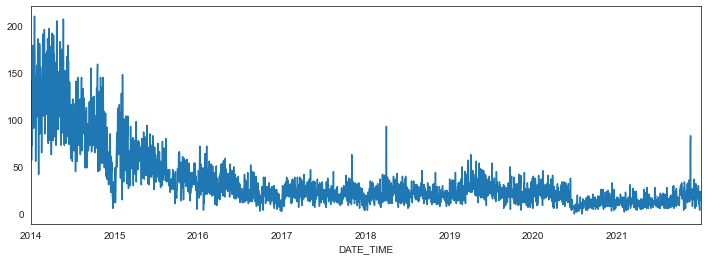

In [1363]:
fourteen_by_day = fourteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('D').sum()
fourteen_by_day.plot()

<AxesSubplot:xlabel='DATE_TIME'>

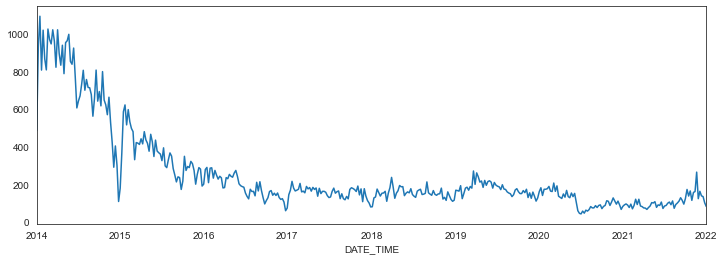

In [1364]:
fourteen_by_week = fourteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('W').sum()
fourteen_by_week.plot()

<AxesSubplot:xlabel='DATE_TIME'>

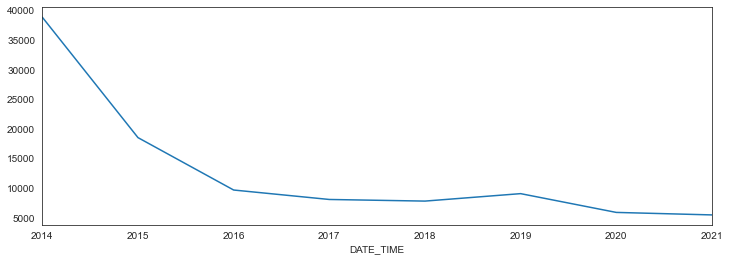

In [1365]:
fourteen_by_year = fourteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('Y').sum()
fourteen_by_year.plot()

## only after the new data system upgrade 

In [1366]:
eighteen_onward = df_dummied.loc['2018':]
eighteen_onward

Unique_ID  SUSPECT_ARRESTED_FLAG_N  \
DATE_TIME                                                 
2018-01-01 00:00:00    1502869                        1   
2018-01-01 00:00:00    1502870                        0   
2018-01-01 00:00:00    1502871                        0   
2018-01-01 00:00:00    1502872                        0   
2018-01-01 00:00:00    1502873                        0   
...                        ...                      ...   
2021-12-31 23:03:00    1545822                        1   
2021-12-31 23:03:00    1545823                        1   
2021-12-31 23:03:00    1545824                        1   
2021-12-31 23:03:00    1545825                        0   
2021-12-31 23:18:00    1545826                        0   

                     SUSPECT_ARRESTED_FLAG_Y  SUSPECT_RACE_DESCRIPTION_BLACK  \
DATE_TIME                                                                      
2018-01-01 00:00:00                        0                               1   
2018-01-01 00:00:00                        1                               1   
2018-01-01 00:00:00                        1                               1   
2018-01-01 00:00:00                        1                               1   
2018-01-01 00:00:00                        1                               1   
...                                      ...                             ...   
2021-12-31 23:03:00                        0                               0   
2021-12-31 23:03:00                        0                               0   
2021-12-31 23:03:00                        0                               0   
2021-12-31 23:03:00                        1                               0   
2021-12-31 23:18:00                        1                               1   

                     SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC  \
DATE_TIME                                                      
2018-01-01 00:00:00                                        0   
2018-01-01 00:00:00                                        0   
2018-01-01 00:00:00                                        0   
2018-01-01 00:00:00                                        0   
2018-01-01 00:00:00                                        0   
...                                                      ...   
2021-12-31 23:03:00                                        0   
2021-12-31 23:03:00                                        0   
2021-12-31 23:03:00                                        0   
2021-12-31 23:03:00                                        0   
2021-12-31 23:18:00                                        0   

                     SUSPECT_RACE_DESCRIPTION_E. ASIAN  \
DATE_TIME                                                
2018-01-01 00:00:00                                  0   
2018-01-01 00:00:00                                  0   
2018-01-01 00:00:00                                  0   
2018-01-01 00:00:00                                  0   
2018-01-01 00:00:00                                  0   
...                                                ...   
2021-12-31 23:03:00                                  0   
2021-12-31 23:03:00                                  0   
2021-12-31 23:03:00                                  0   
2021-12-31 23:03:00                                  0   
2021-12-31 23:18:00                                  0   

                     SUSPECT_RACE_DESCRIPTION_NATIVE  \
DATE_TIME                                              
2018-01-01 00:00:00                                0   
2018-01-01 00:00:00                                0   
2018-01-01 00:00:00                                0   
2018-01-01 00:00:00                                0   
2018-01-01 00:00:00                                0   
...                                              ...   
2021-12-31 23:03:00                                0   
2021-12-31 23:03:00                                0   
2021-12-31 23:03:00                                0   
2021-12-

<AxesSubplot:xlabel='DATE_TIME'>

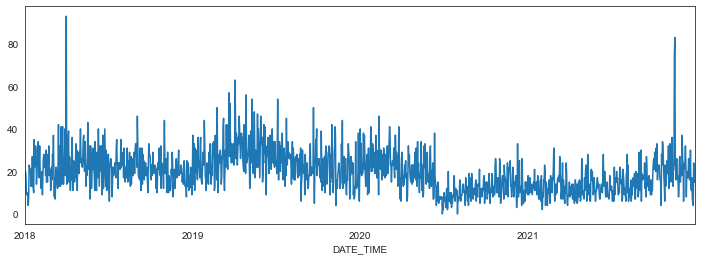

In [1367]:
eighteen_by_day = eighteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('D').sum()
eighteen_by_day.plot()

<AxesSubplot:xlabel='DATE_TIME'>

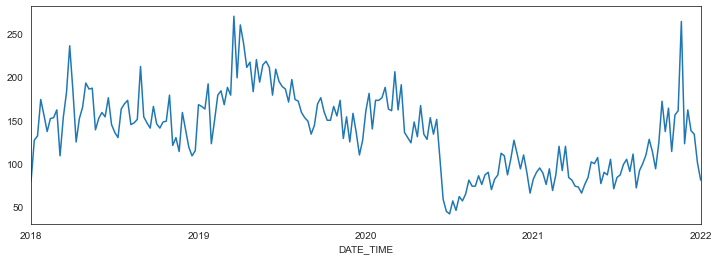

In [1368]:
eighteen_by_week = eighteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('W').sum()
eighteen_by_week.plot()

<AxesSubplot:xlabel='DATE_TIME'>

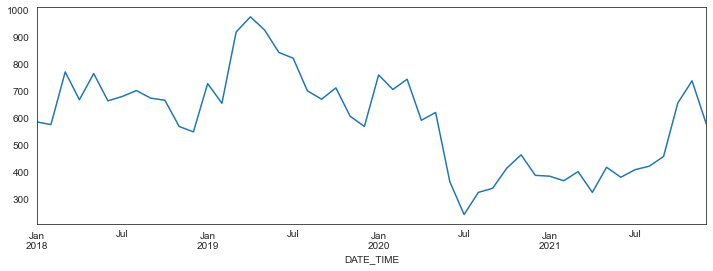

In [1369]:
eighteen_by_month = eighteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('M').sum()
eighteen_by_month.plot()

<AxesSubplot:xlabel='DATE_TIME'>

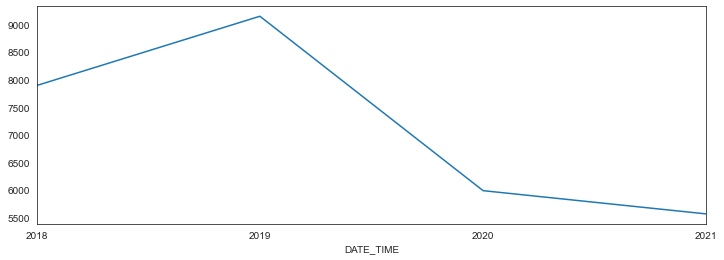

In [1370]:
eighteen_by_year = eighteen_onward['SUSPECT_ARRESTED_FLAG_N'].resample('Y').sum()
eighteen_by_year.plot()

# Getting the Not-Arrested Rate by Week 2014-onward

In [1371]:
#fourteen_onward = fourteen_onward.drop(columns = 'Unique_ID')
fourteen_onward['COUNTS'] = 1
fourteen_onward.head()

<ipython-input-1371-dfad134916e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fourteen_onward['COUNTS'] = 1


Unique_ID  SUSPECT_ARRESTED_FLAG_N  \
DATE_TIME                                                 
2014-01-01 00:10:00    1410486                        1   
2014-01-01 00:20:00    1410487                        0   
2014-01-01 00:30:00    1410488                        1   
2014-01-01 00:30:00    1410489                        1   
2014-01-01 00:30:00    1410490                        1   

                     SUSPECT_ARRESTED_FLAG_Y  SUSPECT_RACE_DESCRIPTION_BLACK  \
DATE_TIME                                                                      
2014-01-01 00:10:00                        0                               1   
2014-01-01 00:20:00                        1                               0   
2014-01-01 00:30:00                        0                               1   
2014-01-01 00:30:00                        0                               1   
2014-01-01 00:30:00                        0                               1   

                     SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC  \
DATE_TIME                                                      
2014-01-01 00:10:00                                        0   
2014-01-01 00:20:00                                        1   
2014-01-01 00:30:00                                        0   
2014-01-01 00:30:00                                        0   
2014-01-01 00:30:00                                        0   

                     SUSPECT_RACE_DESCRIPTION_E. ASIAN  \
DATE_TIME                                                
2014-01-01 00:10:00                                  0   
2014-01-01 00:20:00                                  0   
2014-01-01 00:30:00                                  0   
2014-01-01 00:30:00                                  0   
2014-01-01 00:30:00                                  0   

                     SUSPECT_RACE_DESCRIPTION_NATIVE  \
DATE_TIME                                              
2014-01-01 00:10:00                                0   
2014-01-01 00:20:00                                0   
2014-01-01 00:30:00                                0   
2014-01-01 00:30:00                                0   
2014-01-01 00:30:00                                0   

                     SUSPECT_RACE_DESCRIPTION_OTHER  \
DATE_TIME                                             
2014-01-01 00:10:00                               0   
2014-01-01 00:20:00                               0   
2014-01-01 00:30:00                               0   
2014-01-01 00:30:00                               0   
2014-01-01 00:30:00                               0   

                     SUSPECT_RACE_DESCRIPTION_UNKNOWN  \
DATE_TIME                                               
2014-01-01 00:10:00                                 0   
2014-01-01 00:20:00                                 0   
2014-01-01 00:30:00                                 0   
2014-01-01 00:30:00                                 0   
2014-01-01 00:30:00                                 0   

                     SUSPECT_RACE_DESCRIPTION_W. ASIAN  ...  PRECINCT_111  \
DATE_TIME                                               ...                 
2014-01-01 00:10:00                                  0  ...             0   
2014-01-01 00:20:00                                  0  ...             0   
2014-01-01 00:30:00                                  0  ...             0   
2014-01-01 00:30:00                                  0  ...             0   
2014-01-01 00:30:00                                  0  ...             0   

                     PRECINCT_112  PRECINCT_113  PRECINCT_114  PRECINCT_115  \
DATE_TIME                                                                     
2014-01-01 00:10:00             0             0             0             0   
2014-01-01 00:20:00             0             0             0             0   
2014-01-01 00:30:00             0             0             0             0   
2014-01-01 00:30:00             0             0             0             0 

In [1372]:
fourteen_onward = fourteen_onward.resample('W').sum()
fourteen_onward['NOT_ARRESTED_RATE'] = fourteen_onward['SUSPECT_ARRESTED_FLAG_N'] / fourteen_onward['COUNTS']
fourteen_onward.head()

Unique_ID  SUSPECT_ARRESTED_FLAG_N  SUSPECT_ARRESTED_FLAG_Y  \
DATE_TIME                                                                  
2014-01-05   894448785                    484.0                    150.0   
2014-01-12  1581081040                    926.0                    194.0   
2014-01-19  1880576555                   1092.0                    239.0   
2014-01-26  1391437500                    806.0                    178.0   
2014-02-02  1655713215                   1018.0                    152.0   

            SUSPECT_RACE_DESCRIPTION_BLACK  \
DATE_TIME                                    
2014-01-05                           383.0   
2014-01-12                           626.0   
2014-01-19                           724.0   
2014-01-26                           529.0   
2014-02-02                           611.0   

            SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC  \
DATE_TIME                                             
2014-01-05                                     44.0   
2014-01-12                                     64.0   
2014-01-19                                     86.0   
2014-01-26                                     61.0   
2014-02-02                                     80.0   

            SUSPECT_RACE_DESCRIPTION_E. ASIAN  \
DATE_TIME                                       
2014-01-05                               19.0   
2014-01-12                               49.0   
2014-01-19                               54.0   
2014-01-26                               47.0   
2014-02-02                               55.0   

            SUSPECT_RACE_DESCRIPTION_NATIVE  SUSPECT_RACE_DESCRIPTION_OTHER  \
DATE_TIME                                                                     
2014-01-05                              2.0                             9.0   
2014-01-12                              3.0                             6.0   
2014-01-19                             13.0                            22.0   
2014-01-26                              3.0                            16.0   
2014-02-02                             11.0                            25.0   

            SUSPECT_RACE_DESCRIPTION_UNKNOWN  \
DATE_TIME                                      
2014-01-05                               2.0   
2014-01-12                               9.0   
2014-01-19                               8.0   
2014-01-26                               5.0   
2014-02-02                               4.0   

            SUSPECT_RACE_DESCRIPTION_W. ASIAN  ...  PRECINCT_112  \
DATE_TIME                                      ...                 
2014-01-05                                0.0  ...           5.0   
2014-01-12                                0.0  ...          29.0   
2014-01-19                                0.0  ...          23.0   
2014-01-26                                0.0  ...          27.0   
2014-02-02                                0.0  ...          16.0   

            PRECINCT_113  PRECINCT_114  PRECINCT_115  PRECINCT_120  \
DATE_TIME                                                            
2014-01-05           2.0          11.0           3.0          29.0   
2014-01-12           8.0          31.0           9.0          78.0   
2014-01-19          47.0          26.0           6.0          85.0   
2014-01-26           8.0          17.0           2.0          51.0   
2014-02-02           7.0          34.0          10.0          54.0   

            PRECINCT_121  PRECINCT_122  PRECINCT_123  COUNTS  \
DATE_TIME                                                      
2014-01-05          10.0          12.0           0.0     634   
2014-01-12          30.0          13.0           7.0    1120   
2014-01-19          37.0          27.0           5.0    1331   
2014-01-26          30.0           7.0           1.0     984   
2014-02-02          57.0          42.0           6.0    1170   

            NOT_ARRESTED_RATE  
DATE_TIME                      
2014-01-05           0.763407  
2014-01-12           0.

In [1373]:
fourteen_not_arrested = fourteen_onward.drop(columns= [col for col in fourteen_onward.columns if not col == 'NOT_ARRESTED_RATE'])

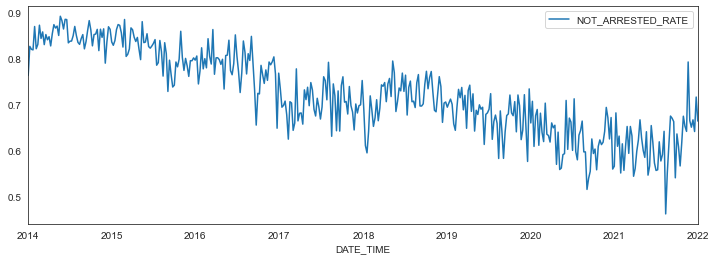

In [1374]:
fourteen_not_arrested_plot = fourteen_not_arrested.plot()

In [1375]:
fourteen_not_arrested.describe()

NOT_ARRESTED_RATE
count         418.000000
mean            0.723417
std             0.090234
min             0.461538
25%             0.655694
50%             0.719096
75%             0.798487
max             0.892473

<AxesSubplot:xlabel='NOT_ARRESTED_RATE', ylabel='Count'>

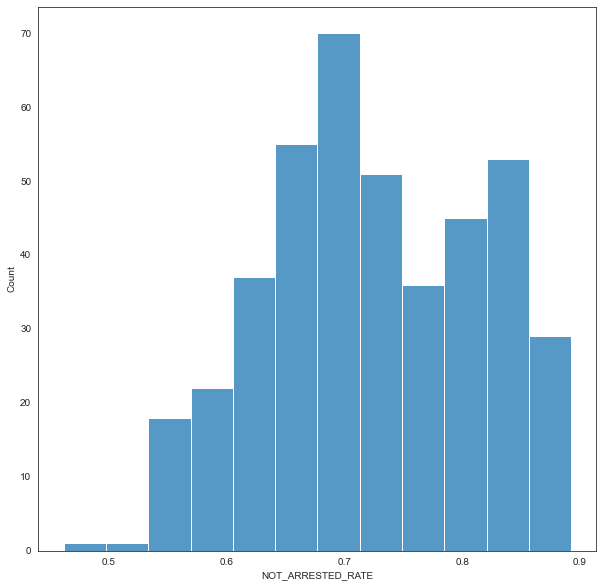

In [1376]:
plt.figure(figsize=(10, 10))

sns.histplot(data = fourteen_not_arrested, x = 'NOT_ARRESTED_RATE', bins= 12)

# how many bins is appropriate for this histogram?

Observations: the distribution isn't a normal distribution exactly, it skews and is somewhat split.

In [1377]:
# Determine rolling statistics
roll_mean = fourteen_not_arrested.rolling(window=52, center=False).mean()
roll_std = fourteen_not_arrested.rolling(window=52, center=False).std()

# What should the window be? Ask Abhineet! 

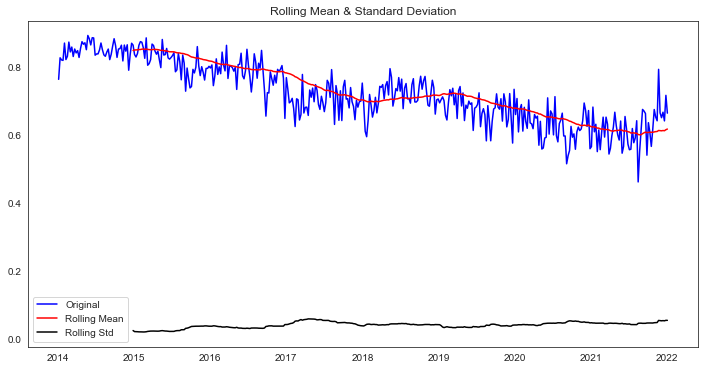

In [1378]:
# Plot rolling statistics
fig = plt.figure(figsize=(12,6))
plt.plot(fourteen_not_arrested, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

# Dickey-Fuller Test

In [1379]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(fourteen_not_arrested['NOT_ARRESTED_RATE'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  -1.604163
p-value                          0.481502
#Lags Used                       6.000000
Number of Observations Used    411.000000
Critical Value (1%)             -3.446361
Critical Value (5%)             -2.868598
Critical Value (10%)            -2.570530
dtype: float64


observations: the P value is above 0.05 so we can reject the null hypothesis, this time series is not stationary and cannot be modeled by ARMA types of models. 


In [1380]:
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(fourteen_not_arrested)  # (0.01, False)
print(f'{p_val} : {should_diff}')

0.03856055273820313 : False


In [1381]:
from pmdarima.arima.utils import ndiffs

n_adf = ndiffs(fourteen_not_arrested, test='adf')
print(n_adf)

0


## Decomposition 

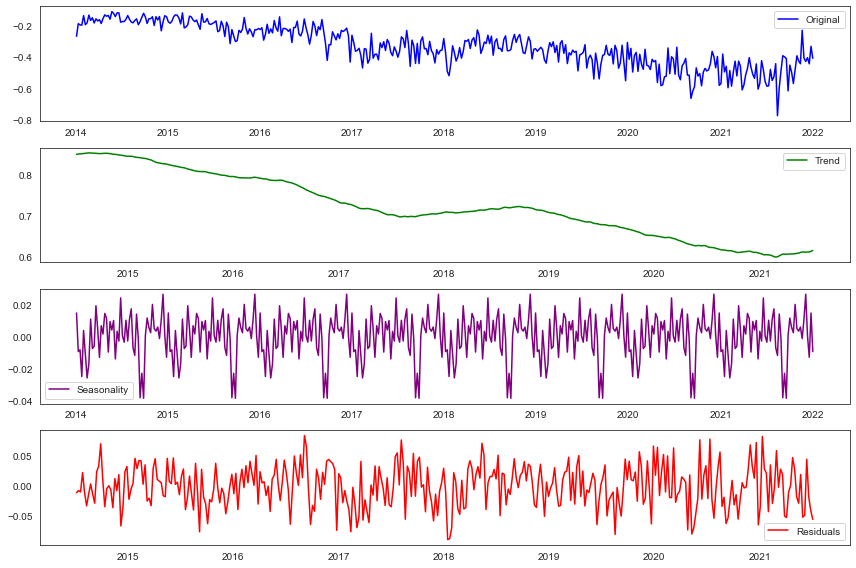

In [1382]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(fourteen_not_arrested, model = "additive")

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(fourteen_not_arrested), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='green')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='purple')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='best')
plt.tight_layout()


# Linear Train Test Split

In [1383]:
cutoff = round(fourteen_not_arrested.shape[0] * 0.8)
cutoff

334

In [1384]:
train = fourteen_not_arrested[:cutoff]
valid = fourteen_not_arrested[cutoff:]

In [1385]:
train.head()

NOT_ARRESTED_RATE
DATE_TIME                    
2014-01-05           0.763407
2014-01-12           0.826786
2014-01-19           0.820436
2014-01-26           0.819106
2014-02-02           0.870085

In [1386]:
train.shape

(334, 1)

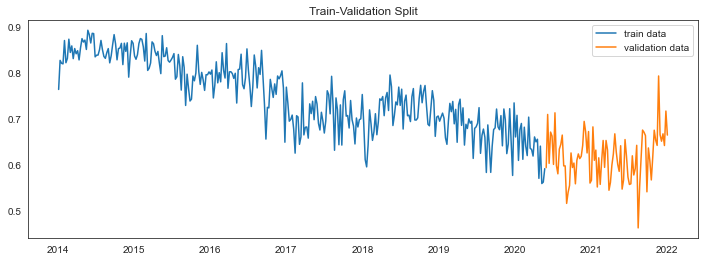

In [1387]:
# visualizing the split

fig, ax = plt.subplots()
ax.plot(train, label = 'train data')
ax.plot(valid, label = 'validation data')

ax.set_title("Train-Validation Split")

plt.legend()

Observations: 

- this data has an overall trend line going down (Green)
- there is repeating seasonality in this data (Purple)
- the noise in the data only accounts for about 20% of the overall rate of not-arrest,(Red) meaning that 80% of the data *is* following the trend and seasonality 

## Investigating if a rolling difference can help us get rid of the trend

Text(0.5, 1.0, 'Differenced Data')

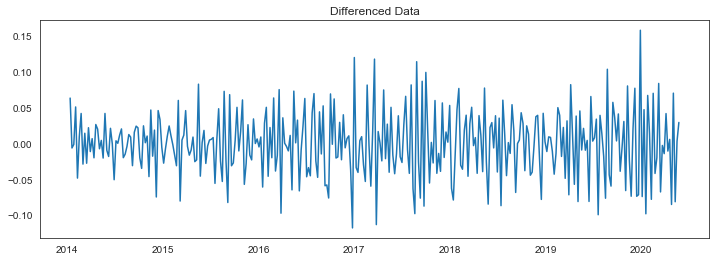

In [1388]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title("Differenced Data")
# observations: this gets rid of the trend but not the seasonaility 

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

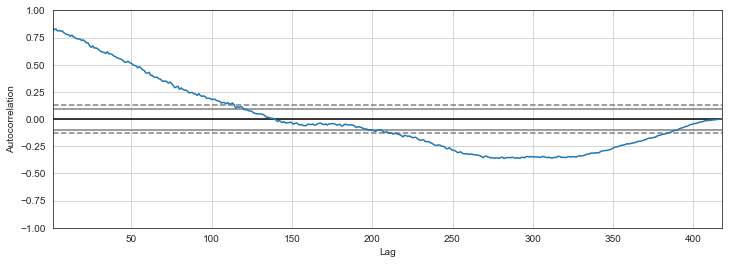

In [1389]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(fourteen_not_arrested)

Observations: most of this plot exists outside of the confidence interval which represents that a majority of the data is not random, and has some correlation either negative or positive with itself. Where the correlation is strongest is within the first 1st-75th lags and again from the 250th-350th lag. Exploring the 52nd lag makes sense as it looked from the decomposition that there is a yearly pattern. 

# ACF and PACF

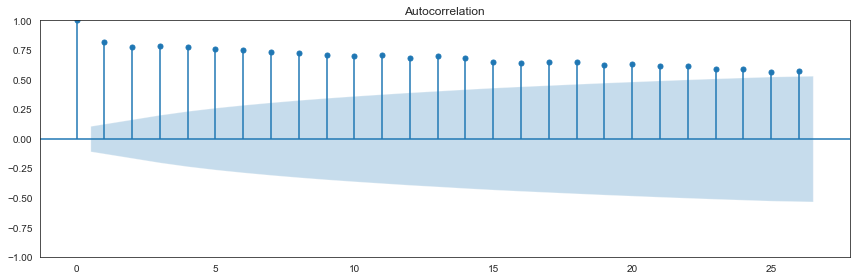

In [1390]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train) 

plt.tight_layout()

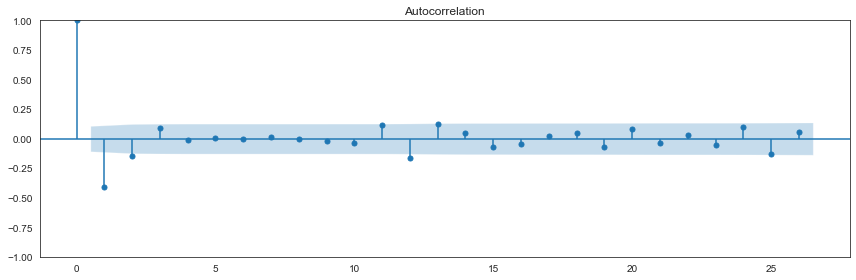

In [1391]:
plot_acf(train.diff().dropna()) 

plt.tight_layout()

Observations: want to include 1 AR terms in final SARIMA Model

/Users/b0ihazard/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


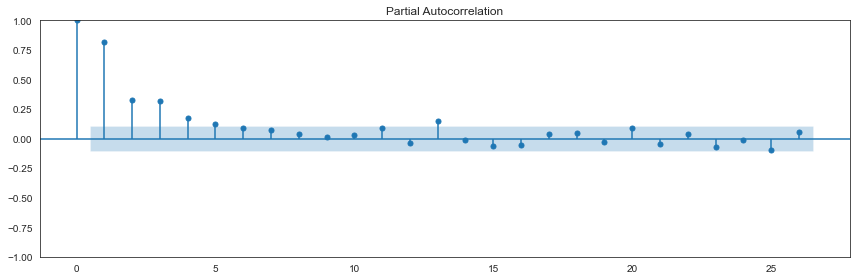

In [1392]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train)

plt.tight_layout()

# number of spikes is maximum p value 

##### explain difference between PACF and ACF! 

/Users/b0ihazard/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


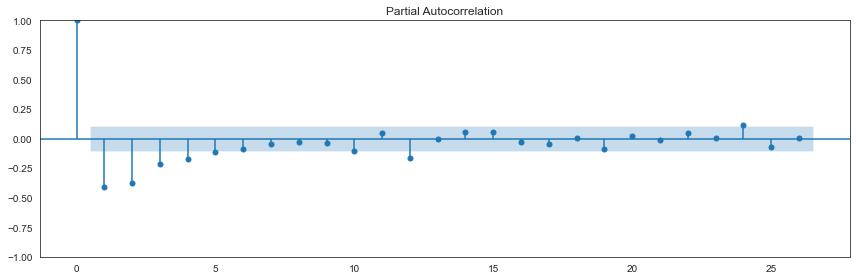

In [1393]:
plot_pacf(train.diff().dropna()) 

plt.tight_layout()

Observations: want to include 2 MA terms in final SARIMA Model

In [1394]:
# Observations: this is showing a monthly pattern of about 5 weeks

# Baseline Model

In [1395]:
naive = train.shift(1)
naive = naive[1::]
naive

NOT_ARRESTED_RATE
DATE_TIME                    
2014-01-12           0.763407
2014-01-19           0.826786
2014-01-26           0.820436
2014-02-02           0.819106
2014-02-09           0.870085
...                       ...
2020-04-26           0.654867
2020-05-03           0.569565
2020-05-10           0.639847
2020-05-17           0.558333
2020-05-24           0.561404

[333 rows x 1 columns]

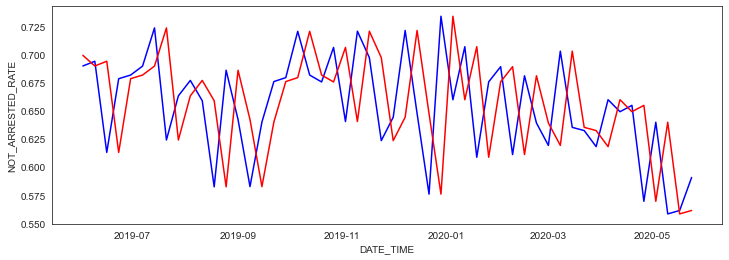

In [1396]:
train_last_year = train[-52::]
naive_last_year = naive[-52::]


train_last_year_plot = sns.lineplot(data = train_last_year,
                                    y = "NOT_ARRESTED_RATE", 
                                    x = train_last_year.index,
                                   color = 'blue', )
naive_last_year_plot = sns.lineplot(data = naive_last_year, 
                               y = "NOT_ARRESTED_RATE", 
                               x = naive_last_year.index,
                              color = 'red', ci = 'sd', err_style = 'bars')

# ask Abhineet why my labels aren't working? 
# ask Abhineet why can't I make the confidence interval show

In [1397]:
get_mae(train[1::], naive)

0.03619726390493658

STANDARD DEVIATION OF RESIDUALS: NOT_ARRESTED_RATE    0.045896
dtype: float64,VARIANCE OF RESIDUALS: NOT_ARRESTED_RATE    0.002106
dtype: float64


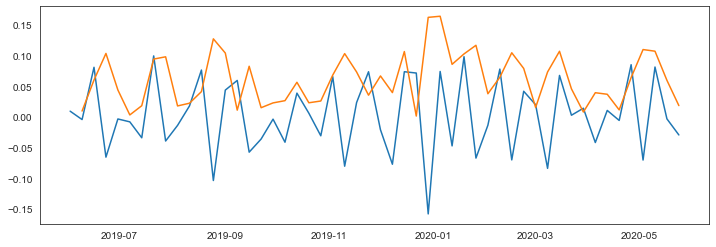

In [1398]:
fig, ax = plt.subplots()
residuals_last_year = naive[-52::] - train[-52::]
ax.plot(residuals_last_year.index, residuals_last_year)
ax.plot(residuals_last_year.index, residuals_last_year.rolling(2).std())

print(f'STANDARD DEVIATION OF RESIDUALS: {residuals.std()},VARIANCE OF RESIDUALS: {residuals.var()}')

# Random Walk Model

In [1399]:
random_walk_model = ARIMA(train, order = (0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      NOT_ARRESTED_RATE   No. Observations:                  334
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 554.074
Date:                Wed, 21 Sep 2022   AIC                          -1106.148
Time:                        19:42:52   BIC                          -1102.340
Sample:                    01-05-2014   HQIC                         -1104.630
                         - 05-24-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0021      0.000     12.860      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                  55.98   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               2.40   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1400]:
random_walk_model.aic

-1106.148479232616

In [1401]:
random_walk_preds = random_walk_model.predict(typ = 'levels')
random_walk_preds_last_year = random_walk_preds[-52::]

get_mae(train, random_walk_preds)

0.09013594083717136

In [1402]:
forecast_last_year = random_walk_model.get_prediction(start = -52)
random_walk_conf_int_last_year = forecast_last_year.conf_int(alpha=0.05)
random_walk_conf_int_last_year.head()

lower NOT_ARRESTED_RATE  upper NOT_ARRESTED_RATE
DATE_TIME                                                   
2019-06-02                 0.609529                 0.789164
2019-06-09                 0.600056                 0.779691
2019-06-16                 0.604262                 0.783896
2019-06-23                 0.523196                 0.702831
2019-06-30                 0.588754                 0.768389

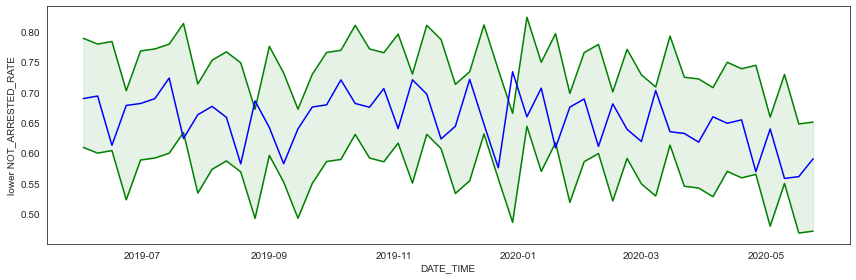

In [1403]:
last_year_visualize_preds(random_walk_conf_int_last_year)

STANDARD DEVIATION OF RESIDUALS: 0.059797142762085045,    VARIANCE OF RESIDUALS: 0.0035756982825091797


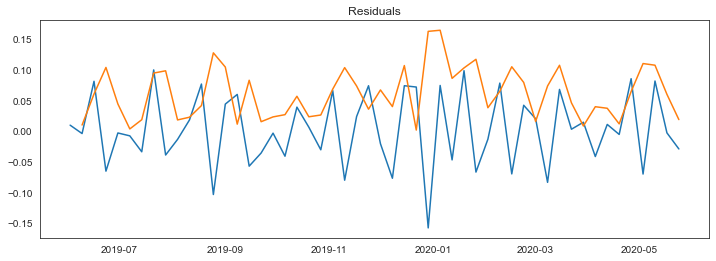

In [1404]:
visualize_diagnostics(random_walk_preds_last_year, train[-52::])

# ARI MODEL

In [1405]:
#from statsmodels.tsa.arima.model.ARIMA import ARIMA

ari_1 = ARIMA(train, order=(1, 1, 0)).fit()
ari_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      NOT_ARRESTED_RATE   No. Observations:                  334
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 584.518
Date:                Wed, 21 Sep 2022   AIC                          -1165.036
Time:                        19:43:06   BIC                          -1157.420
Sample:                    01-05-2014   HQIC                         -1161.999
                         - 05-24-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4084      0.049     -8.276      0.000      -0.505      -0.312
sigma2         0.0017      0.000     13.502      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   8.03   Jarque-Bera (JB):                 2.70
Prob(Q):                              0.00   Prob(JB):                         0.26
Heteroskedasticity (H):               2.19   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- there is a negative relationship between last weeks not-arrested rate and this week's not-arrested rate (this includes the first difference) 
- sigma2 is pretty low to compare, meaning there is little variance 

In [1406]:
ari_1.aic

-1165.0364344877262

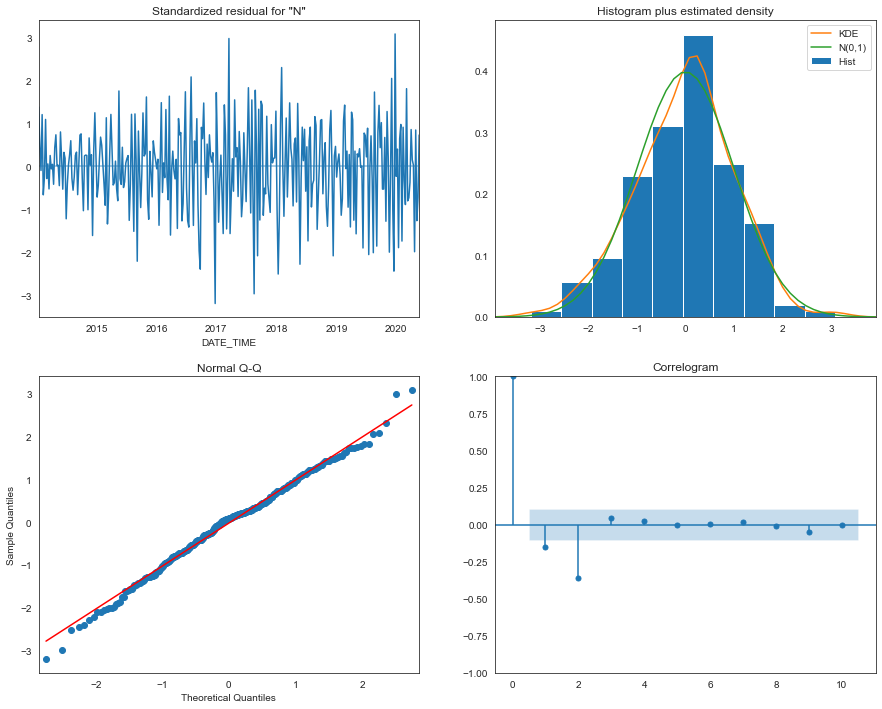

In [1407]:
ari_1.plot_diagnostics(figsize=(15,12))
plt.show()

In [1408]:
ari_1_preds = ari_1.predict(typ = 'levels')
ari_1_preds_last_year = ari_1_preds[-52::]

get_mae(train, ari_1_preds)

0.08813765940400885

In [1409]:
forecast_last_year = ari_1.get_prediction(start = -52)
ari_1_conf_int_last_year = forecast_last_year.conf_int(alpha=0.05)
ari_1_conf_int_last_year.head()

lower NOT_ARRESTED_RATE  upper NOT_ARRESTED_RATE
DATE_TIME                                                   
2019-06-02                 0.608813                 0.772706
2019-06-09                 0.611796                 0.775689
2019-06-16                 0.610415                 0.774308
2019-06-23                 0.564176                 0.728069
2019-06-30                 0.569850                 0.733743

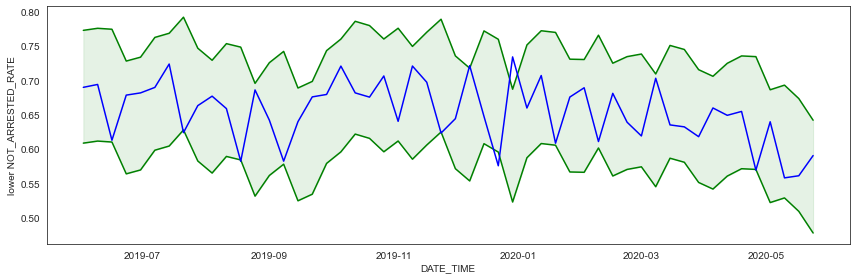

In [1410]:
last_year_visualize_preds(ari_1_conf_int_last_year)

STANDARD DEVIATION OF RESIDUALS: 0.0510467889187553,    VARIANCE OF RESIDUALS: 0.0026057746589159586


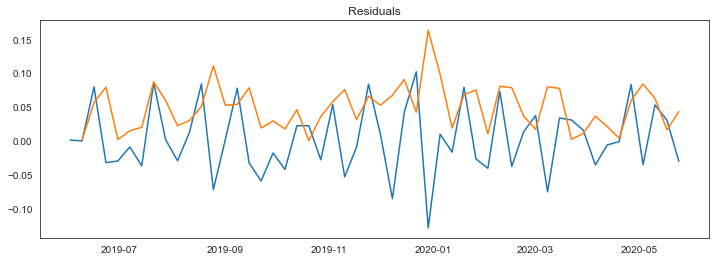

In [1411]:
visualize_diagnostics(ari_1_preds_last_year, train[-52::])

# Auto Regressive Model with 4 time-lags (ARI MODEL)

In [1412]:
ari_2 = ARIMA(train, order=(4, 1, 0)).fit()
ari_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      NOT_ARRESTED_RATE   No. Observations:                  334
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 622.829
Date:                Wed, 21 Sep 2022   AIC                          -1235.657
Time:                        19:43:13   BIC                          -1216.617
Sample:                    01-05-2014   HQIC                         -1228.065
                         - 05-24-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6836      0.055    -12.476      0.000      -0.791      -0.576
ar.L2         -0.5856      0.065     -8.957      0.000      -0.714      -0.457
ar.L3         -0.3241      0.065     -4.980      0.000      -0.452      -0.197
ar.L4         -0.1742      0.054     -3.199      0.001      -0.281      -0.067
sigma2         0.0014   9.72e-05     14.270      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                13.72
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1413]:
ari_2.aic

#observations: we're getting closer 
## methods: I tried up to 12 

-1235.6572282198736

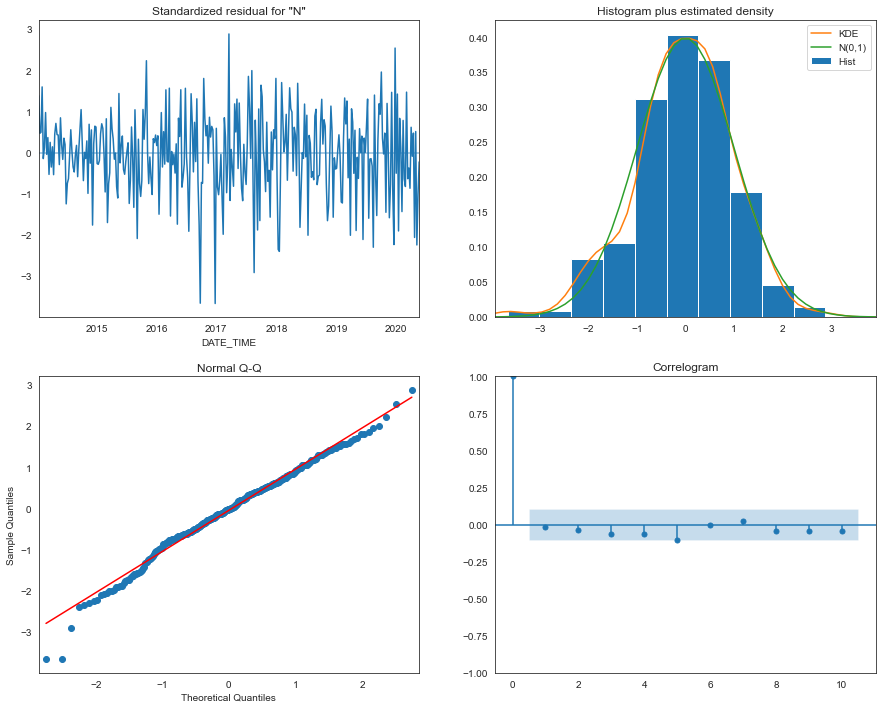

In [1414]:
ari_2.plot_diagnostics(figsize=(15,12))
plt.show()

In [1415]:
ari_2_preds = ari_2.predict(typ = 'levels')
ari_2_preds_last_year = ari_2_preds[-52::]

get_mae(train, ari_2_preds)

0.08630316961560165

In [1416]:
forecast_last_year = ari_2.get_prediction(start = -52)
ari_2_conf_int_last_year = forecast_last_year.conf_int(alpha=0.05)
ari_2_conf_int_last_year.head()

lower NOT_ARRESTED_RATE  upper NOT_ARRESTED_RATE
DATE_TIME                                                   
2019-06-02                 0.616804                 0.762774
2019-06-09                 0.606118                 0.752088
2019-06-16                 0.618552                 0.764522
2019-06-23                 0.592389                 0.738359
2019-06-30                 0.608529                 0.754499

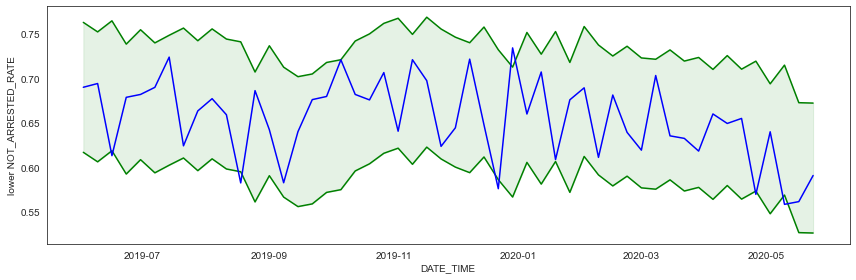

In [1417]:
last_year_visualize_preds(ari_2_conf_int_last_year)

STANDARD DEVIATION OF RESIDUALS: 0.04392131397830586,    VARIANCE OF RESIDUALS: 0.0019290818215809261


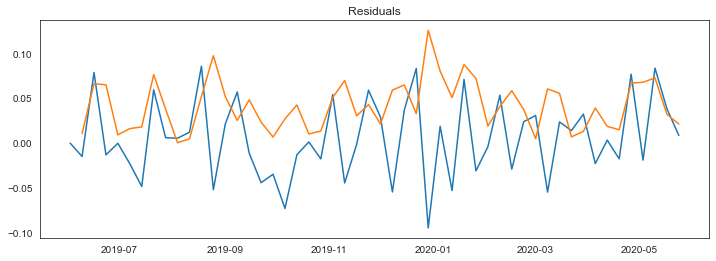

In [1418]:
visualize_diagnostics(ari_2_preds_last_year, train[-52::])

# IMA Model

In [1419]:
ima_1 = ARIMA(train, order = (0, 1, 1)).fit()
ima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      NOT_ARRESTED_RATE   No. Observations:                  334
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 625.679
Date:                Wed, 21 Sep 2022   AIC                          -1247.358
Time:                        19:43:19   BIC                          -1239.741
Sample:                    01-05-2014   HQIC                         -1244.321
                         - 05-24-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7907      0.032    -24.399      0.000      -0.854      -0.727
sigma2         0.0014   9.27e-05     14.697      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (JB):                13.24
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1420]:
ima_1.aic
# observations: this isn't as good as previous models

-1247.3577144018172

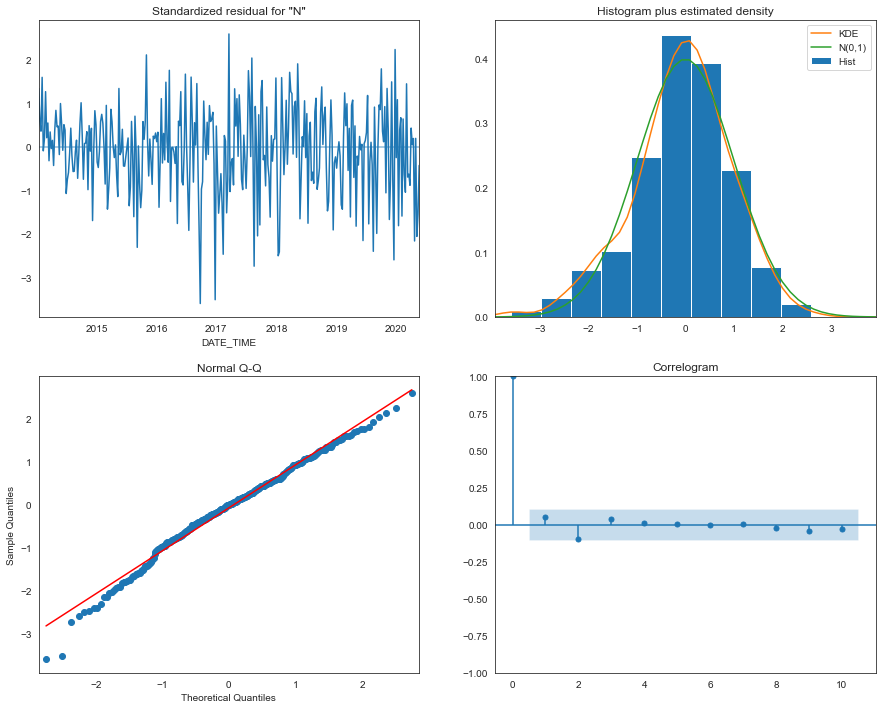

In [1421]:
ima_1.plot_diagnostics(figsize=(15,12))
plt.show()

In [1422]:
ima_1_preds = ima_1.predict(typ = 'levels')
ima_1_preds_last_year = ima_1_preds[-52::]

get_mae(train, ima_1_preds)

0.08535101260086506

In [1423]:
forecast_last_year = ima_1.get_prediction(start = -52)
ima_1_conf_int_last_year = forecast_last_year.conf_int(alpha=0.05)
ima_1_conf_int_last_year.head()

lower NOT_ARRESTED_RATE  upper NOT_ARRESTED_RATE
DATE_TIME                                                   
2019-06-02                 0.619886                 0.764554
2019-06-09                 0.619395                 0.764063
2019-06-16                 0.619887                 0.764555
2019-06-23                 0.603306                 0.747974
2019-06-30                 0.603919                 0.748588

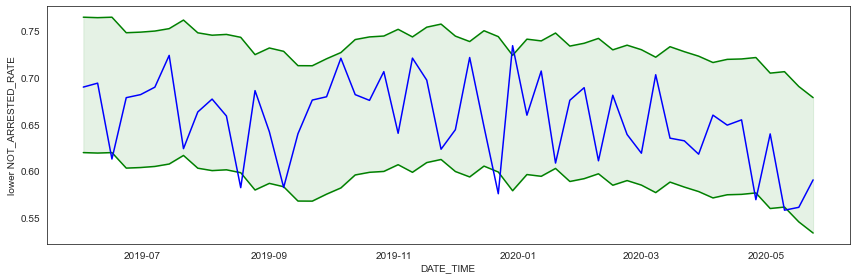

In [1424]:
last_year_visualize_preds(ima_1_conf_int_last_year)

STANDARD DEVIATION OF RESIDUALS: 0.04310168905042664,    VARIANCE OF RESIDUALS: 0.0018577555989996678


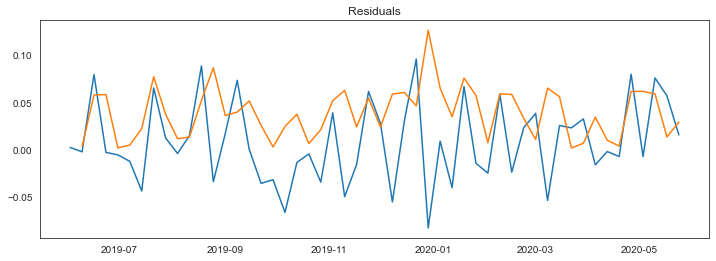

In [1425]:
visualize_diagnostics(ima_1_preds_last_year, train[-52::])

# ARIMA Model with Auto Arima

In [1426]:
# setting m to 6 because it's been 6 years and the season is yearly

sarima_model_params = pm.arima.auto_arima(train, error_action = 'warn', m = 6,
                                          start_p= 0, start_d = 0, start_q = 0, 
                                          start_P = 0, start_D = 0, start_Q = 0,
                                          seasonal= True, trace = True, 
                                          supress_warning = True, 
                                          stepwise = False, 
                                          random_state = 1)

 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=-1104.191, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[6] intercept   : AIC=-1102.193, Time=0.03 sec
 ARIMA(0,1,0)(0,0,2)[6] intercept   : AIC=-1108.679, Time=0.20 sec
 ARIMA(0,1,0)(1,0,0)[6] intercept   : AIC=-1102.195, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[6] intercept   : AIC=-1101.475, Time=0.22 sec
 ARIMA(0,1,0)(1,0,2)[6] intercept   : AIC=-1106.981, Time=0.30 sec
 ARIMA(0,1,0)(2,0,0)[6] intercept   : AIC=-1109.944, Time=0.13 sec
 ARIMA(0,1,0)(2,0,1)[6] intercept   : AIC=-1108.292, Time=0.33 sec
 ARIMA(0,1,0)(2,0,2)[6] intercept   : AIC=-1114.388, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=-1248.010, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=-1246.014, Time=0.15 sec
 ARIMA(0,1,1)(0,0,2)[6] intercept   : AIC=-1246.302, Time=0.36 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=-1246.013, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=-1244.017, Time=0.18 sec
 ARIMA(0,1,1)(1,0,2)[6] intercept   : AIC=-1244.277, Time=0.45

In [1427]:
# auto arima agrees with our ACF and PACF plots after taking a first differnce,
#1 AR term, 1 difference and 2 MA terms

sarima_1 = ARIMA(train, order = (1,1,2)).fit()
sarima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      NOT_ARRESTED_RATE   No. Observations:                  334
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 627.807
Date:                Wed, 21 Sep 2022   AIC                          -1247.614
Time:                        19:43:55   BIC                          -1232.382
Sample:                    01-05-2014   HQIC                         -1241.540
                         - 05-24-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5273      0.301     -1.750      0.080      -1.118       0.063
ma.L1         -0.1836      0.281     -0.653      0.514      -0.735       0.368
ma.L2         -0.5142      0.214     -2.404      0.016      -0.933      -0.095
sigma2         0.0013   9.63e-05     13.961      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                10.18
Prob(Q):                              0.71   Prob(JB):                         0.01
Heteroskedasticity (H):               2.14   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1428]:
sarima_1.aic

-1247.6140781463505

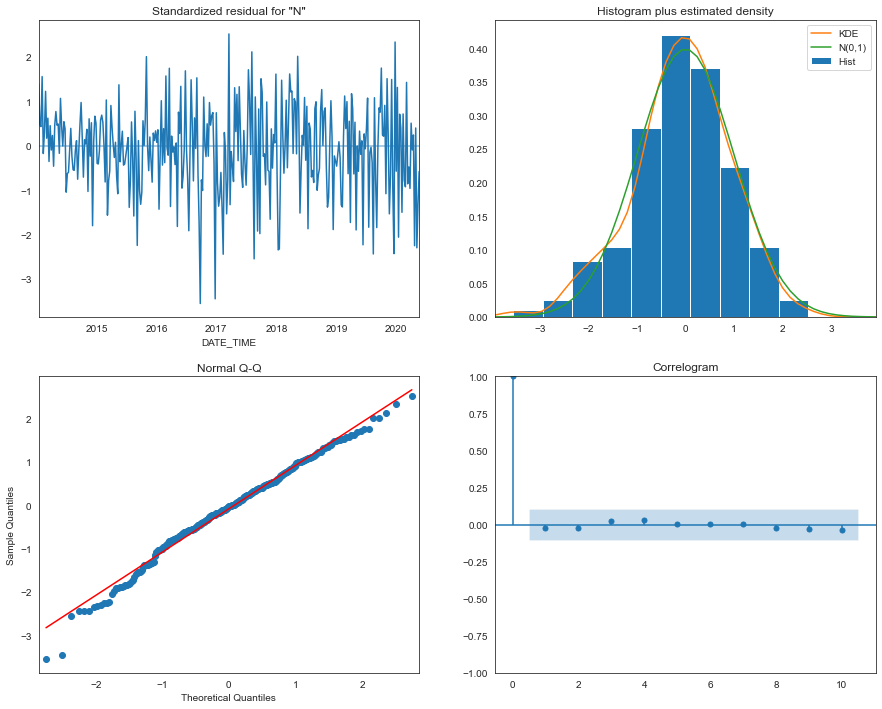

In [1429]:
sarima_1.plot_diagnostics(figsize=(15,12))
plt.show()

In [1430]:
sarima_1_preds = sarima_1.predict(typ = 'levels')
sarima_1_preds_last_year = sarima_1_preds[-52::]

get_mae(train, sarima_1_preds)

0.08534721373033363

In [1431]:
forecast_last_year = sarima_1.get_prediction(start = -52)
sarima_1_conf_int_last_year = forecast_last_year.conf_int(alpha=0.05)
sarima_1_conf_int_last_year.head()

lower NOT_ARRESTED_RATE  upper NOT_ARRESTED_RATE
DATE_TIME                                                   
2019-06-02                 0.624870                 0.768599
2019-06-09                 0.617925                 0.761653
2019-06-16                 0.622737                 0.766466
2019-06-23                 0.596665                 0.740394
2019-06-30                 0.612248                 0.755977

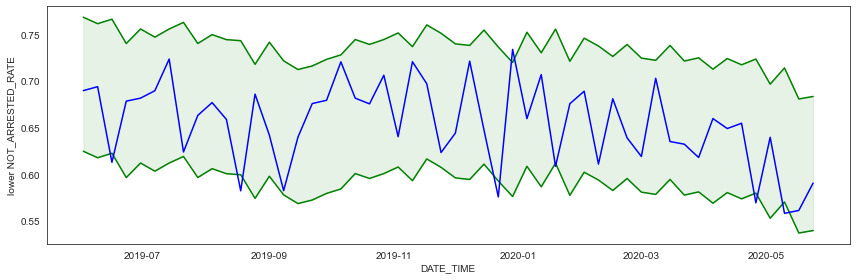

In [1432]:
last_year_visualize_preds(sarima_1_conf_int_last_year)

STANDARD DEVIATION OF RESIDUALS: 0.04362574177944537,    VARIANCE OF RESIDUALS: 0.0019032053458068454


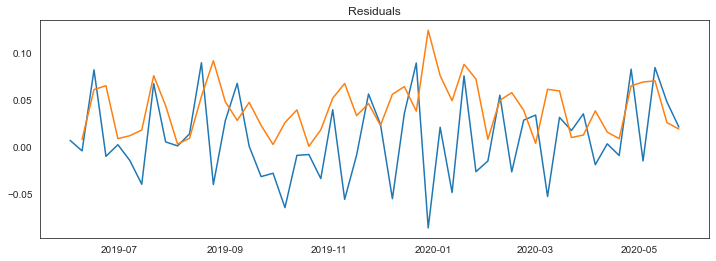

In [1433]:
visualize_diagnostics(sarima_1_preds_last_year, train[-52::])

In [1442]:
twentyone = pd.get_dummies(df['2021-01-01'::])
twentyone.sum()

Unique_ID                                  13790485291
PRECINCT                                        540176
SUSPECT_ARRESTED_FLAG_N                           5564
SUSPECT_ARRESTED_FLAG_Y                           3383
SUSPECT_RACE_DESCRIPTION_BLACK                    5404
SUSPECT_RACE_DESCRIPTION_BLACK HISPANIC            744
SUSPECT_RACE_DESCRIPTION_E. ASIAN                  192
SUSPECT_RACE_DESCRIPTION_NATIVE                      8
SUSPECT_RACE_DESCRIPTION_UNKNOWN                   154
SUSPECT_RACE_DESCRIPTION_WHITE                     732
SUSPECT_RACE_DESCRIPTION_WHITE HISPANIC           1713
dtype: int64

In [1443]:
5564 * 0.08

445.12